# we solve the given PDE using Lagaris approch , you can refer the approch from the paper Lagaris et. al. (1997) https://arxiv.org/pdf/physics/9705023.pdf

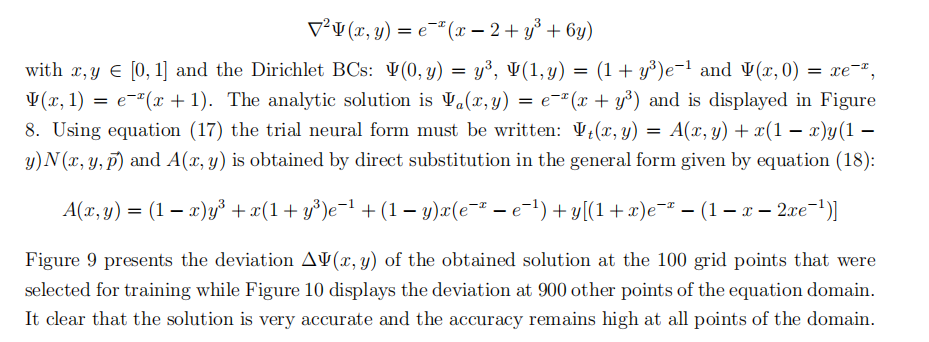

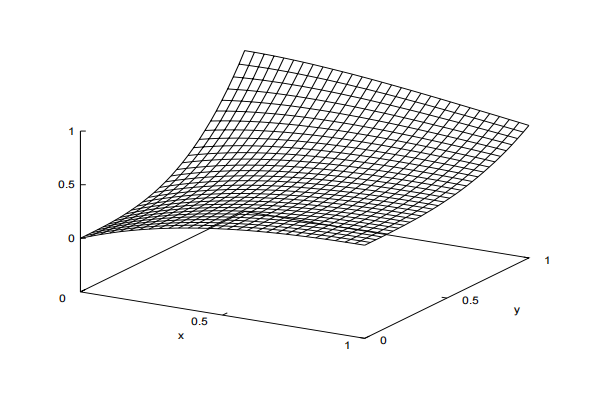


In [ ]:
### model design
import tensorflow as tf
# input layer
input_layer = tf.keras.layers.Input(shape=(2,))
# hidden layer
# also a for loop could be used instead of multiple lines of code
hidden0 = tf.keras.layers.Dense(10, activation="tanh")(input_layer)
# output layer
output_layer = tf.keras.layers.Dense(1, activation=None)(hidden0)

model_lagg = tf.keras.Model(input_layer, output_layer)

model_lagg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_10 (Dense)            (None, 10)                30        
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# u(t, x) just makes working with model easier and the whole code looks more
# like its mathematical backend
@tf.function
def u(x, y):
    # model input shape is (2,) and `u` recieves 2 arguments with shape (1,)
    # to be able to feed those 2 args (t, x) to the model, a shape (2,) matrix
    # is build by simply concatenation of (t, x)
    u = model_lagg(tf.concat([x, y], axis=1)) # note the axis ; `column`
    return u

# IMPORTANT: this loss function is used for collocation points
@tf.function
def f(x, y):

    u0 = u(x, y)
    u_y = tf.gradients(u0, y)[0]
    u_x = tf.gradients(u0, x)[0]
    u_xx = tf.gradients(u_x,x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    u_yx = tf.gradients(u_y,x)[0]
    
    e = tf.exp( tf.cast(tf.constant(1.0), tf.float64))
    e_ = tf.exp(tf.cast(tf.constant(-1.0), tf.float64))

    # A = (1 - x)*y**3 + x*(1 + y**3)*e**(-1) + (1 - y)*x*(e**(-x) - e**(-1)) + y*((1 + x)*e**(-x) - (1 - x - 2*x*e**(-1)))
 
    A = (1 - x)*tf.math.pow(y, 3) + x*(1 + tf.math.pow(y, 3))*e_ + (1 - y)*x*(tf.exp(-x) - e_) + y*((1 + x)*tf.exp(-x) - (1 - x - 2*x*e_))
    N = u_xx + u_yy + 2*u_yx - tf.exp(-x)*(x - 2 + tf.math.pow(y, 3) + 6*y)
    F = A + x*(1 - x)*y*(1 - y)*N

    return tf.reduce_mean(tf.square(F))

### Creating Data 

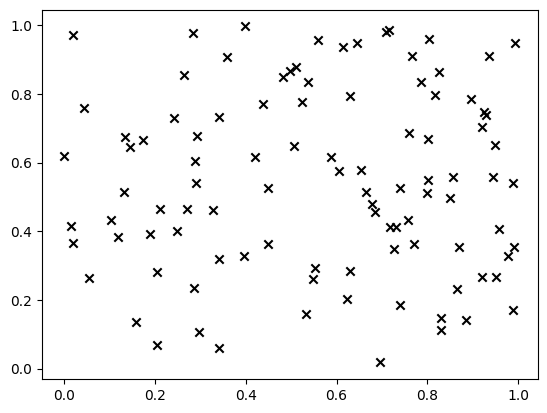

In [ ]:
from matplotlib import cm
import numpy as np
from scipy.stats import qmc

# number of collocation points
Nc = 10000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
data = engine.random(n=Nc)



# change names
x_c = np.expand_dims(data[:, 0], axis=1)
y_c = np.expand_dims(data[:, 1], axis=1)

import matplotlib.pyplot as plt
plt.scatter(x_c[0:100] , y_c[0:100] , marker="x", c="k")

In [ ]:
# convert all data and collocation points to tf.Tensor
x_c, y_c = map(tf.convert_to_tensor, [ x_c, y_c])

In [ ]:
"""
BENCHMARK on Google Colab GPU

learning_rate = 5e-4
epochs = 2000
training time ~ 85.60 s
final loss = 0.006
"""

epochs = 25000
loss_list = []

# L-BFGS optimizer was used in the reference paper
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)

# training loop
# IMPORTANT: a while-based training loop is more beneficial
# updates the model while loss > 0.006
for epoch in range(epochs):
    with tf.GradientTape() as tape:

        # physics-informed loss for collocation points
        L1 = f(x_c, y_c)

        loss = L1 
    # compute gradients
    g = tape.gradient(loss, model_lagg.trainable_weights)
    loss_list.append(loss)
    # log every 10 epochs
    if (not epoch%10) or (epoch == epochs-1):
        print(f"epoch - {epoch:4} /{epochs} : {loss.numpy():.3f}")
    # apply gradients
    opt.apply_gradients(zip(g, model_lagg.trainable_weights))



epoch -    0 /25000 : 0.792
epoch -   10 /25000 : 0.790
epoch -   20 /25000 : 0.788
epoch -   30 /25000 : 0.786
epoch -   40 /25000 : 0.784
epoch -   50 /25000 : 0.781
epoch -   60 /25000 : 0.779
epoch -   70 /25000 : 0.777
epoch -   80 /25000 : 0.774
epoch -   90 /25000 : 0.772
epoch -  100 /25000 : 0.770
epoch -  110 /25000 : 0.767
epoch -  120 /25000 : 0.764
epoch -  130 /25000 : 0.762
epoch -  140 /25000 : 0.759
epoch -  150 /25000 : 0.756
epoch -  160 /25000 : 0.754
epoch -  170 /25000 : 0.751
epoch -  180 /25000 : 0.748
epoch -  190 /25000 : 0.745
epoch -  200 /25000 : 0.742
epoch -  210 /25000 : 0.739
epoch -  220 /25000 : 0.736
epoch -  230 /25000 : 0.733
epoch -  240 /25000 : 0.730
epoch -  250 /25000 : 0.726
epoch -  260 /25000 : 0.723
epoch -  270 /25000 : 0.720
epoch -  280 /25000 : 0.717
epoch -  290 /25000 : 0.713
epoch -  300 /25000 : 0.710
epoch -  310 /25000 : 0.706
epoch -  320 /25000 : 0.703
epoch -  330 /25000 : 0.699
epoch -  340 /25000 : 0.696
epoch -  350 /25000 

Text(0.5, 0, 'epoch')

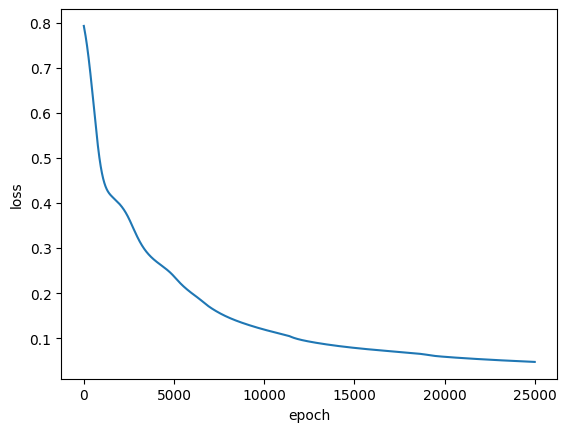

In [ ]:
plt.plot(range(epochs), loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")

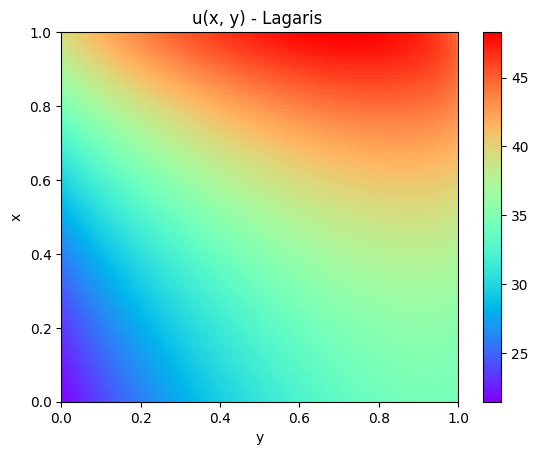

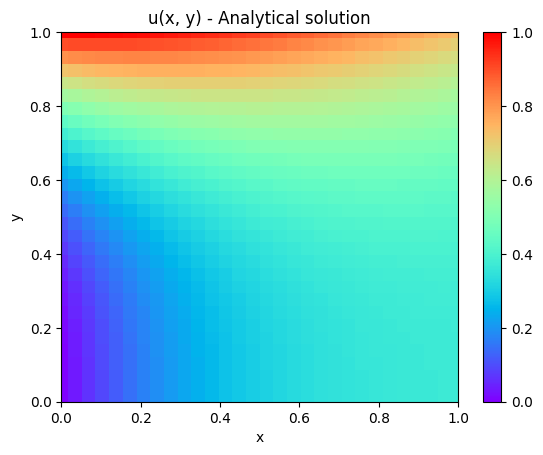

In [ ]:
### plot
# another code is also available for ploting
n, m = 100, 100
X = np.linspace(0, +1, m)
Y = np.linspace(0, 1, n)
X0, Y0 = np.meshgrid(X, Y)
X1 = X0.reshape([n*m, 1])
Y1 = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X1)
Y = tf.convert_to_tensor(Y1)
S1 = u(X , Y)
S = S1.numpy().reshape(m, n)
plt.pcolormesh( X0, Y0 , S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(0, +1)
plt.title("u(x, y) - Lagaris ")
plt.ylabel("x")
plt.xlabel("y")
plt.show()



## Plotting Analytical solution
def ff(x, y):
    return np.exp(-x)*(x + np.power(y , 3))

x = np.linspace(0, 1, 30)
y = np.linspace(0, 1, 30)

X, Y = np.meshgrid(x, y)
Z = ff(X, Y)

plt.pcolormesh(X, Y, Z, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(0, +1)
plt.title("u(x, y) - Analytical solution")
plt.ylabel("y")
plt.xlabel("x")
plt.show()

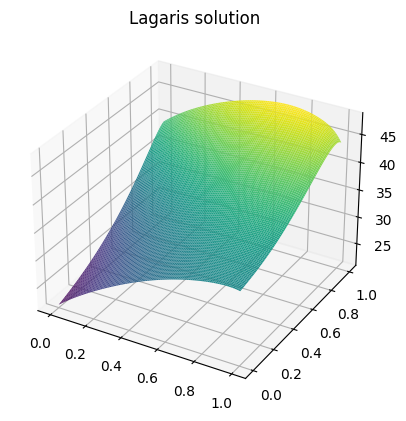

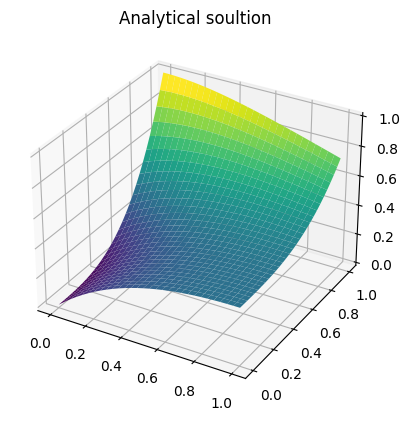

In [ ]:
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
ax.plot_surface(X0, Y0, S, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Lagaris solution');
plt.show()

## Analytical solution 

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Analytical soultion');